In [ ]:
import numpy as np
np.random.seed(13)

from IPython.display import SVG
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter
from gensim.models.doc2vec import Word2Vec

Using Theano backend.


In [ ]:
base_filter()
path = get_file('alice.txt', origin="http://www.gutenberg.org/cache/epub/11/pg11.txt")
corpus = open(path).readlines()[0:200]
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters=base_filter()+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1
dim = 100
window_size = 2

In [ ]:
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        contexts = []
        labels   = []
        L = len(words)
        for index, word in enumerate(words):
            s = index-window_size
            e = index+window_size+1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)

            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            y = np_utils.to_categorical(labels, V)

            yield (x, y)

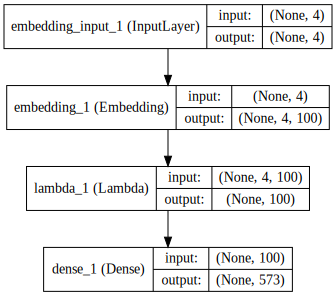

In [ ]:
cbow = Sequential()
cbow.add(Embedding(input_dim=V, output_dim=dim, init='glorot_uniform',input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow.add(Dense(V, init='glorot_uniform', activation='softmax'))
SVG(model_to_dot(cbow, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
cbow.compile(loss='categorical_crossentropy', optimizer="adadelta")

In [ ]:
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow.train_on_batch(x, y)
    print(ite, loss)

0 10494.1636177
1 9312.46828187
2 8359.38306278
3 7632.08460227
4 7084.87363909
5 6631.62655053
6 6240.4081067
7 5896.07164766
8 5580.66496661
9 5282.79390319


In [ ]:
f = open('vectors.txt' ,'w')
f.write(" ".join([str(V-1),str(dim)]))
f.write("\n")

1

In [ ]:
vectors = cbow.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

In [ ]:
w2v = Word2Vec.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
w2v.most_similar(positive=['alice'])

[('burnt', 0.5030882954597473),
 ('\ufeffproject', 0.487962931394577),
 ('taught', 0.39411720633506775),
 ('begun', 0.3898351192474365),
 ('in', 0.38597458600997925),
 ('included', 0.38231587409973145),
 ('several', 0.3809637725353241),
 ('she', 0.3741479814052582),
 ('marked', 0.37243491411209106),
 ('friends', 0.36258465051651)]